In [0]:
!nvidia-smi

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp ./drive/My\ Drive/imagenet.zip ./
!unzip -q imagenet.zip -d ./imagenet
!cp ./drive/My\ Drive/gen.pt ./
!cp ./drive/My\ Drive/disc.pt ./
!cp ./drive/My\ Drive/runs.zip ./
!unzip -q runs.zip

In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, utils
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import time
from torch.utils.tensorboard import SummaryWriter
import os
from PIL import Image

In [0]:
dir = './imagenet/imagenet_images'
for x in os.listdir(dir):
  im = Image.open(os.path.join(dir, x))
  if(im.mode != 'RGB'):
    print(x, im.mode)
    get_ipython().system_raw(f'rm {os.path.join(dir, x)} &')

In [0]:
!rm -rf runs/

In [0]:
%load_ext tensorboard
!mkdir runs
%tensorboard --logdir runs --port 6006 --samples_per_plugin images=200

In [0]:
# Tunnel localhost to a webpage using ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('tensorboard --logdir runs --host 0.0.0.0 --port 6006 --samples_per_plugin images=200 &')
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class TrainDataset(Dataset):

  def __init__(self):
    super().__init__()
    dir = './imagenet/imagenet_images'
    self.img = [os.path.join(dir, x) for x in os.listdir(dir)]
    self.hr = transforms.Compose([
                                  transforms.RandomCrop(96, pad_if_needed=True),
                                  transforms.ToTensor(),
                                  #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    self.lr = transforms.Compose([
                                  transforms.ToPILImage(),
                                  transforms.Resize(24, interpolation=Image.BICUBIC),
                                  transforms.ToTensor()
    ])
  
  def __getitem__(self, index):
    hr_image = self.hr(Image.open(self.img[index]))
    lr_image = self.lr(hr_image)
    return lr_image, hr_image

  def __len__(self):
    return len(self.img)

In [0]:
dataset = TrainDataset()
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8)

torch.Size([128, 3, 24, 24]) torch.Size([128, 3, 96, 96])


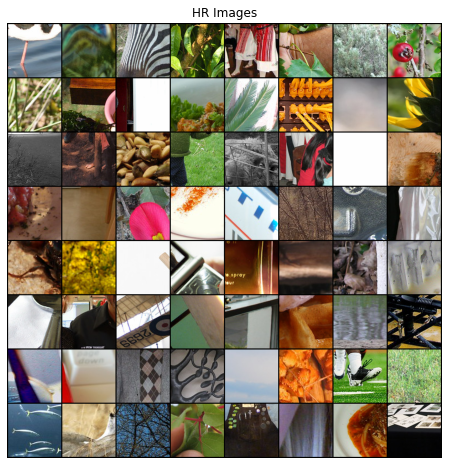

In [0]:
real_batch = next(iter(dataloader))
print(real_batch[0].shape, real_batch[1].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("HR Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[1].to(device)[:64], nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
class FeatureExtractor(nn.Module):
  
  def __init__(self, model, i, j):
    super().__init__()
    maxpool = [4, 9, 18, 27, 36]
    layer = maxpool[i-1]-2*j
    self.features = nn.Sequential(*list(model.features.children())[:(layer+1)])
    
  def forward(self, x):
    return self.features(x)

In [0]:
class ResidualBlock(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(64, 64, 3, 1, 1)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(64)

  def forward(self, x):
    y = self.conv1(x)
    y = self.bn1(y)
    y = self.relu1(y)
    y = self.conv2(y)
    y = self.bn2(y)
    return x + y

In [0]:
class UpsampleBlock(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(64, 256, 3, 1, 1)
    self.shuffle = nn.PixelShuffle(2)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.shuffle(x)
    x = self.relu(x)
    return x

In [0]:
class Generator(nn.Module):

  def __init__(self, b):
    super().__init__()
    self.b = b
    self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
    self.relu = nn.ReLU()
    for i in range(b):
      self.add_module(f'ResidualBlock_{i+1}', ResidualBlock())
    self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
    self.bn = nn.BatchNorm2d(64)
    for i in range(2):
      self.add_module(f'UpsampleBlock_{i+1}', UpsampleBlock())
    self.conv3 = nn.Conv2d(64, 3, 9, 1, 4)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    y = x.clone()
    for i in range(self.b):
      y = self.__getattr__(f'ResidualBlock_{i+1}')(y)
    y = self.conv2(y)
    y = self.bn(y)
    y = y + x
    for i in range(2):
      y = self.__getattr__(f'UpsampleBlock_{i+1}')(y)
    y = self.conv3(y)
    return y

In [0]:
class DiscriminatorBlock(nn.Module):

  def __init__(self, in_channels, out_channels, stride):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.bn = nn.BatchNorm2d(out_channels)
  
  def forward(self, x):
    x = self.conv(x)
    x = self.leaky_relu(x)
    x = self.bn(x)
    return x

In [0]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.add_module('DiscriminatorBlock1', DiscriminatorBlock(64, 64, 2))
    n = 128
    for i in range(3):
      self.add_module(f'DiscriminatorBlock{2+2*i}', DiscriminatorBlock(n//2, n, 1))
      self.add_module(f'DiscriminatorBlock{3+2*i}', DiscriminatorBlock(n, n, 2))
      n *= 2
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.conv2 = nn.Conv2d(512, 1024, 1)
    self.conv3 = nn.Conv2d(1024, 1, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.leaky_relu(self.conv1(x))
    for i in range(7):
      x = self.__getattr__(f'DiscriminatorBlock{i+1}')(x)
    x = self.avgpool(x)
    x = self.leaky_relu(self.conv2(x))
    x = self.sigmoid(self.conv3(x))
    x = x.view(-1,1)
    return x

In [0]:
vgg = models.vgg19(pretrained=True)
feature_extractor = FeatureExtractor(vgg, 5, 4).to(device)
summary(feature_extractor, (3,96,96))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256

In [0]:
disc = Discriminator().to(device)
disc.load_state_dict(torch.load('disc.pt'))
summary(disc, (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
         LeakyReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 48, 48]          36,928
         LeakyReLU-4           [-1, 64, 48, 48]               0
       BatchNorm2d-5           [-1, 64, 48, 48]             128
DiscriminatorBlock-6           [-1, 64, 48, 48]               0
            Conv2d-7          [-1, 128, 48, 48]          73,856
         LeakyReLU-8          [-1, 128, 48, 48]               0
       BatchNorm2d-9          [-1, 128, 48, 48]             256
DiscriminatorBlock-10          [-1, 128, 48, 48]               0
           Conv2d-11          [-1, 128, 24, 24]         147,584
        LeakyReLU-12          [-1, 128, 24, 24]               0
      BatchNorm2d-13          [-1, 128, 24, 24]             256
DiscriminatorBlock-14          [-1, 12

In [0]:
gen = Generator(16).to(device)
gen.load_state_dict(torch.load('gen.pt'))
summary(gen, (3,24,24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,792
              ReLU-2           [-1, 64, 24, 24]               0
            Conv2d-3           [-1, 64, 24, 24]          36,928
       BatchNorm2d-4           [-1, 64, 24, 24]             128
              ReLU-5           [-1, 64, 24, 24]               0
            Conv2d-6           [-1, 64, 24, 24]          36,928
       BatchNorm2d-7           [-1, 64, 24, 24]             128
     ResidualBlock-8           [-1, 64, 24, 24]               0
            Conv2d-9           [-1, 64, 24, 24]          36,928
      BatchNorm2d-10           [-1, 64, 24, 24]             128
             ReLU-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,928
      BatchNorm2d-13           [-1, 64, 24, 24]             128
    ResidualBlock-14           [-1, 64,

In [0]:
content_criterion = nn.MSELoss()
adversarial_criterion = nn.BCELoss()
lr = 1e-5
optimG = optim.Adam(gen.parameters(), lr)
optimD = optim.Adam(disc.parameters(), lr)

In [0]:
# Generator pre-training
writer = SummaryWriter()
start_time = time.time()
for epoch in range(5):

  for i, data in enumerate(dataloader, 0):

    lr, hr_real = data
    hr_real = hr_real.to(device)
    lr = lr.to(device)

    batch_size = hr_real.size()[0]
    hr_fake = gen(lr)

    gen.zero_grad()
    gen_content_loss = content_criterion(hr_fake, hr_real)
    gen_content_loss.backward()
    optimG.step()

    if i % 50 == 0:
      print(f'[{epoch}/5][{i}/{len(dataloader)}] Gen_MSE: {gen_content_loss.item()}')

    if i == len(dataloader)-2:
      hr_real_grid = utils.make_grid(hr_real[:64], nrow=8, padding=2, normalize=True)
      lr_grid = utils.make_grid(lr[:64], nrow=8, padding=2, normalize=True)
      hr_fake_grid = utils.make_grid(hr_fake.detach()[:64], nrow=8, padding=2, normalize=True)
      writer.add_image('Pre/HR Real', hr_real_grid, epoch)
      writer.add_image('Pre/LR', lr_grid, epoch)
      writer.add_image('Pre/HR Fake', hr_fake_grid, epoch)
      writer.close()
  print(f'Time Elapsed: {(time.time()-start_time): .2f}')

[0/5][0/316] Gen_MSE: 0.3070802390575409
[0/5][50/316] Gen_MSE: 0.016320182010531425
[0/5][100/316] Gen_MSE: 0.012789119966328144
[0/5][150/316] Gen_MSE: 0.010391602292656898
[0/5][200/316] Gen_MSE: 0.00946641992777586
[0/5][250/316] Gen_MSE: 0.008556563407182693
[0/5][300/316] Gen_MSE: 0.009059722535312176
Time Elapsed:  169.41
[1/5][0/316] Gen_MSE: 0.007447464857250452
[1/5][50/316] Gen_MSE: 0.007868095301091671
[1/5][100/316] Gen_MSE: 0.007196796126663685
[1/5][150/316] Gen_MSE: 0.0061194743029773235
[1/5][200/316] Gen_MSE: 0.006286320276558399
[1/5][250/316] Gen_MSE: 0.006298352032899857
[1/5][300/316] Gen_MSE: 0.0067658801563084126
Time Elapsed:  321.43
[2/5][0/316] Gen_MSE: 0.006932084448635578
[2/5][50/316] Gen_MSE: 0.007565229199826717
[2/5][100/316] Gen_MSE: 0.004748723469674587
[2/5][150/316] Gen_MSE: 0.007167612202465534
[2/5][200/316] Gen_MSE: 0.005947394762188196
[2/5][250/316] Gen_MSE: 0.004961197730153799
[2/5][300/316] Gen_MSE: 0.005735726095736027
Time Elapsed:  470.35

In [0]:
writer = SummaryWriter()

In [0]:
start_time = time.time()
num_epochs = 60
iters = 0
for epoch in range(53, num_epochs):

  for i, data in enumerate(dataloader):
    iters += 1
    lr, hr_real = data
    batch_size = hr_real.size()[0]
    hr_real = hr_real.to(device)
    lr = lr.to(device)
    hr_fake = gen(lr)

    # Label Smoothing (Salimans et. al. 2016)
    target_real = torch.rand(batch_size, 1, device=device)*0.85+0.3
    target_fake = torch.rand(batch_size, 1, device=device)*0.15

    # Discriminator
    disc.zero_grad()
    D_x = disc(hr_real)
    D_G_z1 = disc(hr_fake.detach())
    errD_real = adversarial_criterion(D_x, target_real)
    errD_fake = adversarial_criterion(D_G_z1, target_fake)
    errD = errD_real + errD_fake
    D_x = D_x.view(-1).mean().item()
    D_G_z1 = D_G_z1.view(-1).mean().item()
    errD.backward()
    optimD.step()

    # Generator
    gen.zero_grad()
    real_features = feature_extractor(hr_real)
    fake_features = feature_extractor(hr_fake)
    ones = torch.ones(batch_size, 1, device=device)

    errG_mse = content_criterion(hr_fake, hr_real)
    errG_vgg = content_criterion(fake_features, real_features)
    D_G_z2 = disc(hr_fake)
    errG_adv = adversarial_criterion(D_G_z2, ones)
    errG = errG_mse + 0.006*errG_vgg + 0.001*errG_adv
    D_G_z2 = D_G_z2.view(-1).mean().item()
    errG.backward()
    optimG.step()

    if i % 20 == 0:
      print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] errD: {errD.item():.4f}'
      f' errG: {errG.item():.4f} ({errG_mse.item():.4f}/{0.006*errG_vgg.item():.4f}/{0.001*errG_adv.item():.4f}) D(HR): {D_x :.4f} D(G(LR1)): {D_G_z1:.4f} D(G(LR2)): {D_G_z2:.4f}')
      """writer.add_scalars('Loss/Gen',{'mse':errG_mse.item(), 'vgg':0.006*errG_vgg.item(), 'adv':0.003*errG_adv.item(), 'total':errG.item()},iters)
      writer.add_scalars('Loss/Disc',{'real':errD_real.item(), 'fake':errD_fake.item(), 'total':errD.item()},iters)
      writer.add_scalars('Values',{'D(HR)':D_x,'D(LR1):':D_G_z1,'D(LR2)':D_G_z2},iters)
      writer.close()"""

    if i == len(dataloader)-2:
      hr_real_grid = utils.make_grid(hr_real[:64], nrow=8, padding=2, normalize=True)
      lr_grid = utils.make_grid(lr[:64], nrow=8, padding=2, normalize=True)
      hr_fake_grid = utils.make_grid(hr_fake.detach()[:64], nrow=8, padding=2, normalize=True)
      writer.add_image('Train/HR Real', hr_real_grid, epoch)
      writer.add_image('Train/LR', lr_grid, epoch)
      writer.add_image('Train/HR Fake', hr_fake_grid, epoch)
      writer.close()
  
  torch.save(gen.state_dict(), f'./gen.pt')
  torch.save(disc.state_dict(), f'./disc.pt')
  print(f'Time Elapsed: {(time.time()-start_time): .2f}')

In [0]:
%tensorboard --logdir runs